# Filling HUC12 / FIPS Codes

In [63]:
import pandas as pd
import fiona
import matplotlib.pyplot as plt
import geopandas as gpd
from shapely.geometry import Point, Polygon, LineString
from pyproj import Proj
import geoplot as gplt
import geoplot.crs as gcrs

## Read in HUC12

In [2]:
# Get HUC12
layers = fiona.listlayers('./Data/huc12.gdb')
layers

['WBDHU12']

In [76]:
huc12 = gpd.read_file('./Data/huc12.gdb', layer = 'WBDHU12')

In [77]:
# converting to lat long
huc12.crs = {'init' :'epsg:2283'}

/anaconda3/lib/python3.7/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


In [81]:
bay_states = ['NY', 'PA', 'VA', 'MD', 'WV', 'DE', 'DC']

In [82]:
keep = []
for i in bay_states:
    for x in huc12['STATES'].unique():
        if i in x:
            keep.append(x)
        else:
            pass

In [83]:
keephuc = huc12[huc12['STATES'].isin(keep)]

In [84]:
keephuc.shape

(5366, 20)

In [85]:
keephuc['STATES'].unique()

array(['DE', 'DE,MD', 'CN,NY', 'DE,MD,PA', 'DE,NJ', 'DE,PA',
       'CN,MI,OH,PA', 'CN,MI,NY,OH,PA', 'CT,NY', 'CT,NY,RI', 'MD',
       'MD,PA', 'KY,VA', 'MD,PA,WV', 'MD,VA', 'VA', 'MD,VA,WV', 'MD,WV',
       'MA,NY', 'NY,VT', 'MA,NY,VT', 'KY,OH,WV', 'KY,TN,VA', 'KY,VA,WV',
       'KY,WV', 'NC,VA', 'NC,TN,VA', 'NY', 'OH,PA', 'NJ,NY', 'OH,WV',
       'NJ,NY,PA', 'NJ,PA', 'DE,NJ,PA', 'NY,PA', 'PA', 'OH,PA,WV',
       'PA,WV', 'TN,VA', 'VA,WV', 'WV', 'CT,MA,NY', 'NY,RI', 'CN,NY,VT',
       'DC,MD,VA', 'DC,MD'], dtype=object)

In [86]:
keephuc.head(2)

,TNMID,METASOURCEID,SOURCEDATADESC,SOURCEORIGINATOR,SOURCEFEATUREID,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC12,NAME,HUTYPE,HUMOD,TOHUC,NONCONTRIBUTINGAREAACRES,NONCONTRIBUTINGAREASQKM,Shape_Length,Shape_Area,geometry
5497,{9C83472B-0B5D-48B8-9382-B6AAD67E37F2},None,None,None,None,2013-01-18T07:08:10,NaN,13348.68,54.02,DE,020402070401,Spring Branch-Murderkill River,S,DM,020402070404,0.0,0.0,0.441869,0.005616,"MULTIPOLYGON (((-75.52011 38.99948, -75.52001 ..."
5498,{47BB3A4D-1C14-46A2-926B-78F9891CDC8F},None,None,None,None,2013-01-18T07:08:10,NaN,12514.82,50.65,DE,020402070402,Browns Branch,S,DM,020402070404,0.0,0.0,0.502473,0.005262,"MULTIPOLYGON (((-75.48657 38.93200, -75.48697 ..."


## Read in County

In [20]:
# read in county boundaries
counties = gpd.read_file('./Data/tl_2017_us_county/tl_2017_us_county.shp')

In [24]:
# fips codes
fips = pd.read_csv('./Data/statefips.csv')

In [26]:
fips['fips'] = ['0' + str(i) if len(str(i)) == 1 else str(i) for i in fips['fips']]
fipsdict = dict(zip(fips['fips'], fips['abbr']))
counties['state'] = counties['STATEFP'].map(fipsdict)
counties['fullfips'] = counties['STATEFP'] + counties['COUNTYFP']

In [28]:
keep_counties = counties[counties['state'].isin(bay_states)]

In [29]:
keep_counties.shape

(345, 20)

## Read in Water & Benthic Data

In [33]:
water = pd.read_csv('./Data/Water.csv', low_memory = False)

In [113]:
benthic = pd.read_csv('./Data/Benthic.csv', low_memory = False)

In [114]:
# getting geospatial point for each lat/lon
water['Point'] = [Point(x, y) for x, y in zip(water['Longitude'], water['Latitude'])]
benthic['Point'] = [Point(x, y) for x, y in zip(benthic['Longitude'], benthic['Latitude'])]

In [38]:
# get unique points
water_collections = water[['Longitude', 'Latitude']].drop_duplicates()
water_collections.shape

(2544, 2)

In [40]:
benthic_collections = benthic[['Longitude', 'Latitude']].drop_duplicates()
benthic_collections.shape

(5508, 2)

In [43]:
allpoints = pd.concat([water_collections,benthic_collections], axis = 0, sort = True)
allpoints.drop_duplicates(inplace = True)
allpoints.shape

(8040, 2)

In [46]:
allpoints['Point'] = [Point(x, y) for x, y in zip(allpoints['Longitude'], allpoints['Latitude'])]

## Get HUC12 

In [90]:
# get list of HUC12 for each point
hucs = []
names = []
for i in allpoints['Point']:
    
    huc = ""
    name = ""
    for x, y, z in zip(keephuc['NAME'], keephuc['HUC12'], keephuc['geometry']):
            
        if z.contains(i) == True:
            name = x
            huc = y
            break
        else:
            pass
            
    hucs.append(huc)
    names.append(name)
    
allpoints['HUC12'] = hucs
allpoints['HUCNAME'] = names

## Get FIPS codes

In [59]:
# get list of HUC12 for each point
fips = []
states = []
counties = []
for i in allpoints['Point']:
    
    fip = ""
    state = ""
    county = ""
    for w, x, y, z in zip(keep_counties['fullfips'], keep_counties['state'], keep_counties['NAMELSAD'], keep_counties['geometry']):
            
        if z.contains(i) == True:
            fip = w
            state = x
            county = y
            break
        else:
            pass
            
    fips.append(fip)
    states.append(state)
    counties.append(county)
    
allpoints['FIPS'] = fips
allpoints['STATE'] = states
allpoints['COUNTY'] = counties

In [66]:
allpoints = allpoints.dropna()

## Plots

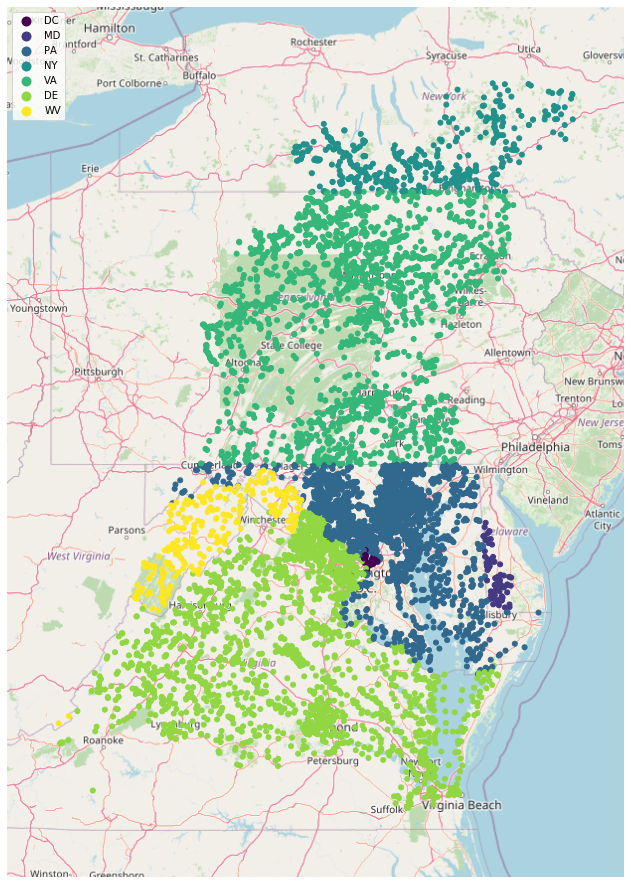

In [94]:
geometry = allpoints['Point']
crs = {'init': 'epsg:4326'}
gdf = gpd.GeoDataFrame(allpoints[['STATE']], crs=crs, geometry=geometry)
ax = gplt.webmap(gdf, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf, hue= 'STATE', ax=ax, k = gdf['STATE'].nunique(), legend_labels = list(gdf['STATE'].unique()), legend = 'True')

### Map back to Dataframes

In [96]:
county_dict = dict(zip(allpoints['Point'].map(str), allpoints['COUNTY']))
state_dict = dict(zip(allpoints['Point'].map(str), allpoints['STATE']))
fips_dict = dict(zip(allpoints['Point'].map(str), allpoints['FIPS']))
huc_dict = dict(zip(allpoints['Point'].map(str), allpoints['HUC12']))
hucname_dict = dict(zip(allpoints['Point'].map(str), allpoints['HUCNAME']))

In [ ]:
# mapping water values
water['HUC12_'] = water['Point'].map(str).map(huc_dict)
water['HUCNAME_'] = water['Point'].map(str).map(hucname_dict)
water['FIPS_'] = water['Point'].map(str).map(fips_dict)
water['COUNTY_'] = water['Point'].map(str).map(county_dict)
water['STATE_'] = water['Point'].map(str).map(state_dict)

In [115]:
# mapping benthic values
benthic['HUC12_'] = benthic['Point'].map(str).map(huc_dict)
benthic['HUCNAME_'] = benthic['Point'].map(str).map(hucname_dict)
benthic['FIPS_'] = benthic['Point'].map(str).map(fips_dict)
benthic['COUNTY_'] = benthic['Point'].map(str).map(county_dict)
benthic['STATE_'] = benthic['Point'].map(str).map(state_dict)

## Plotting Maps

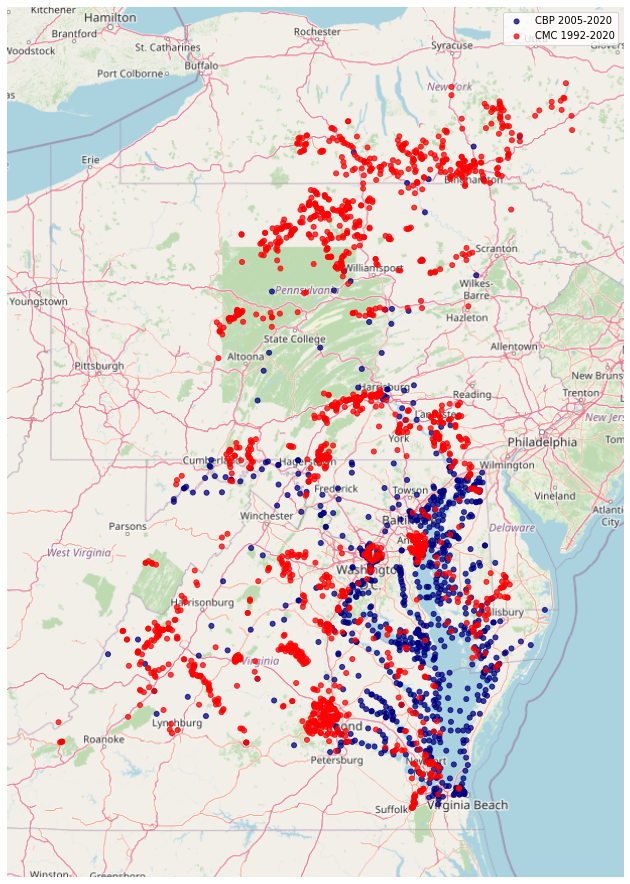

In [129]:
# plotting water
water_cbp = water[water['Database']=='CBP'].drop_duplicates(subset = ['Latitude', 'Longitude'])
water_cmc = water[water['Database']=='CMC'].drop_duplicates(subset = ['Latitude', 'Longitude'])

geometry1 = water_cbp['Point']
geometry2 = water_cmc['Point']
crs = {'init': 'epsg:4326'}
gdf1 = gpd.GeoDataFrame(water_cbp[['Database']], crs=crs, geometry=geometry1)
gdf2 = gpd.GeoDataFrame(water_cmc[['Database']], crs=crs, geometry=geometry2)

ax = gplt.webmap(gdf2, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf1, color = 'navy', ax=ax, alpha = 0.75, label = 'CBP 2005-2020')
gplt.pointplot(gdf2, color = 'red', ax=ax, alpha = 0.75, label = 'CMC 1992-2020')
plt.legend()

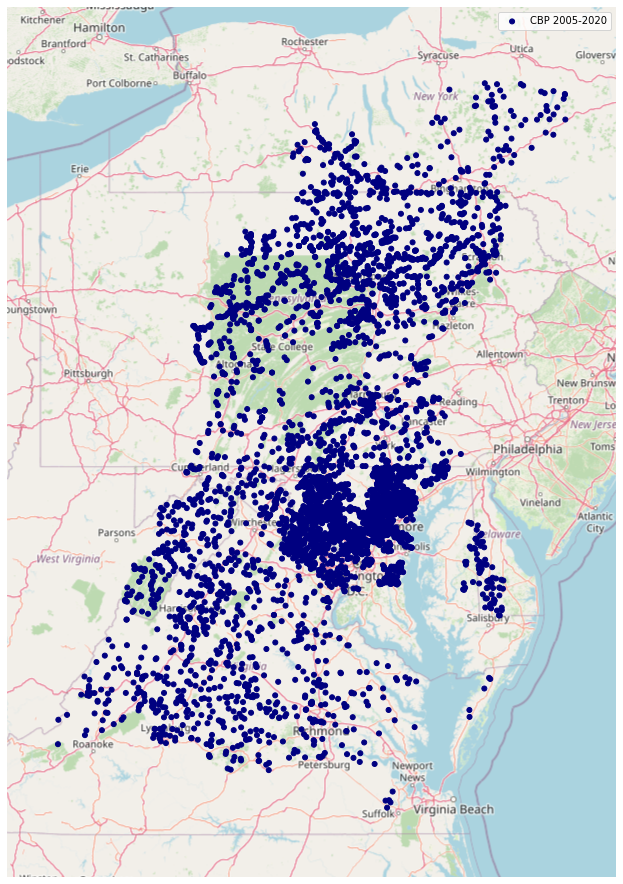

In [128]:
# plotting water
benthic_cbp = benthic[benthic['Database']=='CBP'].drop_duplicates(subset = ['Latitude', 'Longitude'])
benthic_cmc = benthic[benthic['Database']=='CMC'].drop_duplicates(subset = ['Latitude', 'Longitude'])

benthic_cbp = benthic_cbp.dropna(subset = ['Latitude', 'Longitude'])

geometry1 = benthic_cbp['Point']
geometry2 = benthic_cmc['Point']
crs = {'init': 'epsg:4326'}
gdf1 = gpd.GeoDataFrame(benthic_cbp[['Database']], crs=crs, geometry=geometry1)
gdf2 = gpd.GeoDataFrame(benthic_cmc[['Database']], crs=crs, geometry=geometry2)

ax = gplt.webmap(gdf1, figsize = (16, 16), projection=gcrs.WebMercator())
gplt.pointplot(gdf1, color = 'navy', ax=ax, label = 'CBP 2005-2020')
#gplt.pointplot(gdf2, color = 'red', ax=ax, label = 'CMC 1992-2020')
plt.legend()

#  to csv

In [133]:
water.to_csv('./Data/Water_FINAL.csv')

In [134]:
water.head()

,Unnamed: 0,Agency,BiasPC,CloudCover,Comments,Cruise,Database,Date,FieldActivityEventType,FieldActivityRemark,...,Weather Conditions Yesterday,WindDirection,WindSpeed,state,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,39,NaN,NaN,NaN,NaN,NaN,CMC,03/15/2018,NaN,NaN,...,NaN,NaN,NaN,DC,POINT (-77.00291999999997 38.86972),020700100204,Lower Anacostia River,11001,District of Columbia,DC
1,42,NaN,NaN,NaN,NaN,NaN,CMC,04/11/2018,NaN,NaN,...,NaN,NaN,NaN,DC,POINT (-77.00291999999997 38.86972),020700100204,Lower Anacostia River,11001,District of Columbia,DC
2,43,NaN,NaN,NaN,NaN,NaN,CMC,04/11/2018,NaN,NaN,...,NaN,NaN,NaN,DC,POINT (-77.00291999999997 38.86972),020700100204,Lower Anacostia River,11001,District of Columbia,DC
3,59,NaN,NaN,NaN,NaN,NaN,CMC,04/16/2018,NaN,NaN,...,NaN,NaN,NaN,DC,POINT (-77.00291999999997 38.86972),020700100204,Lower Anacostia River,11001,District of Columbia,DC
4,60,NaN,NaN,NaN,NaN,NaN,CMC,04/16/2018,NaN,NaN,...,NaN,NaN,NaN,DC,POINT (-77.00291999999997 38.86972),020700100204,Lower Anacostia River,11001,District of Columbia,DC


In [135]:
water.isnull().sum()

Unnamed: 0                                       0
Agency                                      264261
BiasPC                                     2720455
CloudCover                                  477694
Comments                                   2621968
Cruise                                      264261
Database                                         0
Date                                             0
FieldActivityEventType                     2523570
FieldActivityRemark                        2720510
FlowStage                                  2714579
GaugeHeight                                2620369
GroupCode                                  2456249
HUC12                                       264261
Lab                                        1846344
Latitude                                         0
Layer                                       264812
Longitude                                        0
LowerPycnocline                            2295567
MeasureValue                   

In [138]:
benthic.dropna(subset = ['Latitude'], inplace = True)

In [140]:
benthic.head()

,Unnamed: 0,Active Construction,Agency,Algae Color,Algae Located,Aquatic Veg/Decaying Matter,Area 1 Sampled,Area 2 Sampled,Area 3 Sampled,Area 4 Sampled,...,Vegetated,Vegetated Jabs,Weather Conditions,Weather Last 72 Hours,Point,HUC12_,HUCNAME_,FIPS_,COUNTY_,STATE_
0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-77.044167 38.971944),020700100102,Lower Rock Creek,11001,District of Columbia,DC
1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-77.044167 38.971944),020700100102,Lower Rock Creek,11001,District of Columbia,DC
2,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-77.044167 38.971944),020700100102,Lower Rock Creek,11001,District of Columbia,DC
3,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-77.044167 38.971944),020700100102,Lower Rock Creek,11001,District of Columbia,DC
4,4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,POINT (-77.05264200000001 38.938253),020700100102,Lower Rock Creek,11001,District of Columbia,DC


In [139]:
benthic.isnull().sum()

Unnamed: 0                            0
Active Construction              169494
Agency                            41433
Algae Color                      167958
Algae Located                    168210
Aquatic Veg/Decaying Matter      171098
Area 1 Sampled                   170749
Area 2 Sampled                   170887
Area 3 Sampled                   171077
Area 4 Sampled                   171087
Barriers To Fish Movement        167783
Benthic Classification Code      129671
Benthic Classification Name           0
BioMethod                         41433
Bottom Type                      156649
Channel Width                    170044
Collection Time (Net 1)          156715
Collection Time (Net 2)          162800
Collection Time (Net 3)          167601
Collection Time (Net 4)          169322
Comments                         167198
Count                                 0
CountyCity                        41433
Cropland                         169478
Database                              0


In [145]:
benthic.to_csv('./Data/Benthic_FINAL.csv')